# Life Expectancy Linear Regression Model

Goal: Predict average healthy life expectancy at birth per country using supervised linear regression 

Impact: Better understanding of where healthcare resources should be allocated to increase life expectancy in a particular country. 

## Part 1: Build DataFrame

Load data set and save it as a pandas dataframe
* World Happiness Report (WHR) data set: `WHR2018Chapter2OnlineData.csv`

In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [9]:
WHRDataSet_filename = os.path.join(os.getcwd(), "WHR2018Chapter2OnlineData.csv")

df = pd.read_csv(WHRDataSet_filename)
df.head()
print(df.columns)

Index(['country', 'year', 'Life Ladder', 'Log GDP per capita',
       'Social support', 'Healthy life expectancy at birth',
       'Freedom to make life choices', 'Generosity',
       'Perceptions of corruption', 'Positive affect', 'Negative affect',
       'Confidence in national government', 'Democratic Quality',
       'Delivery Quality', 'Standard deviation of ladder by country-year',
       'Standard deviation/Mean of ladder by country-year',
       'GINI index (World Bank estimate)',
       'GINI index (World Bank estimate), average 2000-15',
       'gini of household income reported in Gallup, by wp5-year'],
      dtype='object')


## Part 2: Understand Data

Data preparation plan
    
    * remove missing values and replace with mean
    * find and replace outliers
    * combine data from same countries respectively to boost efficiency 
    * remove irrelevant features 
    * one-hot encoding on categorical features 
    
Logisitic regression model to analyze
Graph the difference between testing and training results to prevent overfitting

## Part 3: Data Cleaning

In [10]:
# make a feature list with all the features
feature_list = df.columns.tolist()
feature_list.remove('Healthy life expectancy at birth')

# HANDLING MISSING DATA
missing = df.isnull().sum()
threshold = 100
clean_features = [col for col in feature_list if missing[col] <= threshold]
df = df[clean_features + ['Healthy life expectancy at birth']]

# missing indicators
for col in ['Log GDP per capita', 'Social support', 'Freedom to make life choices', 
            'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']:
    if col in df.columns:
        df[col + '_na'] = df[col].isnull()

# fill missing with mean
df = df.fillna(df.mean(numeric_only=True))

# drop irrelevant columnds
cols_to_drop = [
    'GINI index (World Bank estimate)',
    'GINI index (World Bank estimate), average 2000-15',
    'Confidence in national government',
    'gini of household income reported in Gallup, by wp5-year',
    'Delivery Quality',
    'Democratic Quality',
]
df = df.drop(columns=cols_to_drop, errors='ignore')

# remove year column and average values of countries through the years
if 'year' in df.columns:
    df = df.drop(columns=['year'], errors='ignore')

df_avg = df.groupby('country').mean(numeric_only=True).reset_index()


## Part 4: Model Training 
 
* data scaling
* outlier detection and removal
* model training and evaluation
* hyperparameter tuning with GridSearchCV
* feature importance visualization
* feature filtering and retraining

In [11]:
# DEFINING FEATURES AND LABEL
label = 'Healthy life expectancy at birth'

# remove country column
df_model = df_avg.drop(columns=['country'], errors='ignore').dropna(subset=[label])

# define X and y
X = df_model.drop(columns=[label])
y = df_model[label]

# scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ridge for outlier detection
ridge = Ridge(alpha=1.0)
ridge.fit(X_scaled, y)
residuals = y - ridge.predict(X_scaled)
std_residuals = (residuals - np.mean(residuals)) / np.std(residuals)
outlier_mask = np.abs(std_residuals) > 3
X_no_outliers = X[~outlier_mask]
y_no_outliers = y[~outlier_mask]

# splitting in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_no_outliers, y_no_outliers, test_size=0.25, random_state=123)

Baseline Linear Regression → MSE: 23.24, R²: 0.62


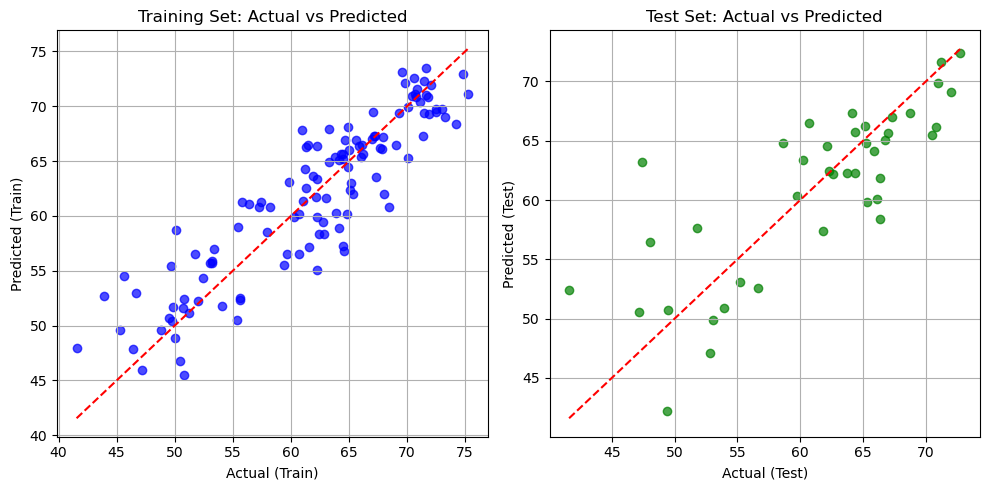

Average CV R² score: 0.6415
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best alpha: 10
Best cross-validated R²: 0.7302
Test MSE: 18.0144
Test R²: 0.7090


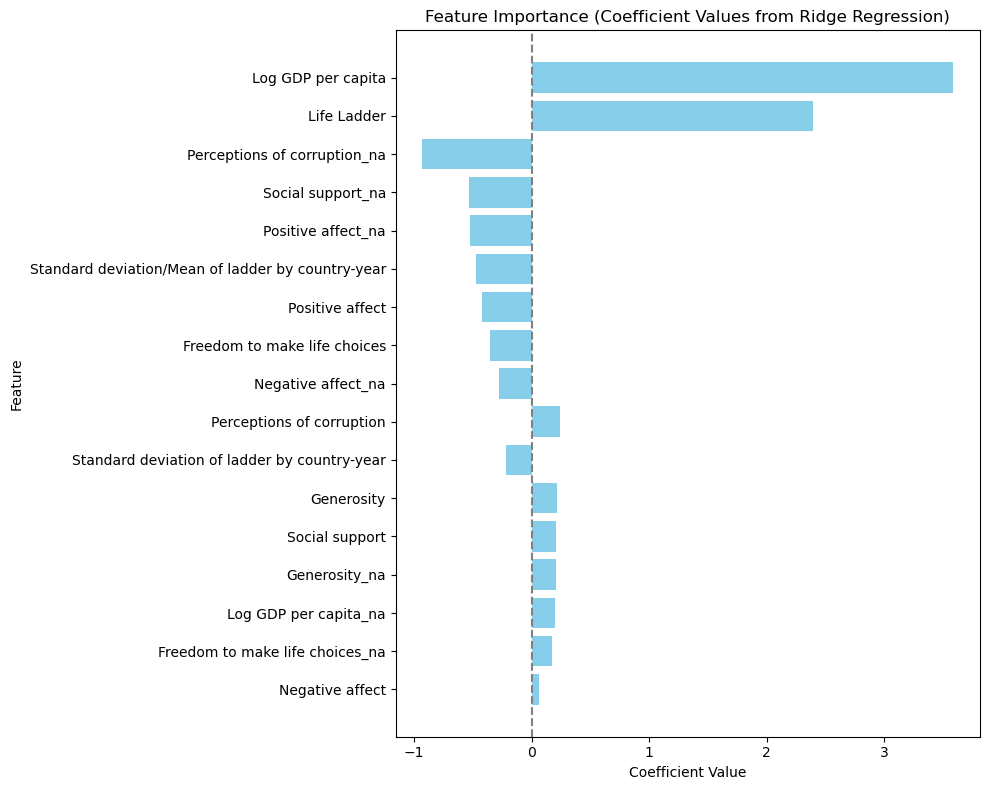

Features to keep:
['Life Ladder', 'Log GDP per capita', 'Social support', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect', 'Standard deviation of ladder by country-year', 'Standard deviation/Mean of ladder by country-year', 'Log GDP per capita_na', 'Social support_na', 'Freedom to make life choices_na', 'Generosity_na', 'Perceptions of corruption_na', 'Positive affect_na', 'Negative affect_na']
Filtered Test R²: 0.6676
No features were dropped.


In [12]:
# BASELINE LINEAR REGRESSION
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)
print(f"Baseline Linear Regression → MSE: {mean_squared_error(y_test, y_pred):.2f}, R²: {r2_score(y_test, y_pred):.2f}")

plt.figure(figsize=(10,5))

# Training set
plt.subplot(1, 2, 1)
plt.scatter(y_train, lr_model.predict(X_train), alpha=0.7, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Actual (Train)')
plt.ylabel('Predicted (Train)')
plt.title('Training Set: Actual vs Predicted')
plt.grid(True)

# Test set
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual (Test)')
plt.ylabel('Predicted (Test)')
plt.title('Test Set: Actual vs Predicted')
plt.grid(True)

plt.tight_layout()
plt.show()

# cross validation
scores = cross_val_score(lr_model, X_no_outliers, y_no_outliers, cv=5, scoring='r2')
print(f"Average CV R² score: {scores.mean():.4f}")

# grid search for ridge regression 
ridge = Ridge(random_state=123)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 200]}

grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=2,
    verbose=1
)
grid_search.fit(X_train, y_train)

print("Best alpha:", grid_search.best_params_['alpha'])
print(f"Best cross-validated R²: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

# feature importance plot
feature_names = X.columns
coefs = best_model.coef_

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df_sorted = coef_df.sort_values(by='Abs_Coefficient', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color='skyblue')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Feature Importance (Coefficient Values from Ridge Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# feature selection and retraining
threshold = 0.05
features_to_keep = coef_df[coef_df['Abs_Coefficient'] > threshold]['Feature'].tolist()
print("Features to keep:")
print(features_to_keep)

X_filtered = pd.DataFrame(X_no_outliers, columns=X.columns)[features_to_keep]

X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_filtered, y_no_outliers, test_size=0.2, random_state=123
)

final_model = Ridge(alpha=grid_search.best_params_['alpha'])
final_model.fit(X_train_f, y_train_f)
y_pred_f = final_model.predict(X_test_f)

print(f"Filtered Test R²: {r2_score(y_test_f, y_pred_f):.4f}")

# check dropped features
dropped = set(X.columns) - set(features_to_keep)
if dropped:
    print("Dropped features:")
    for f in dropped:
        print("-", f)
else:
    print("No features were dropped.")

In [13]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300, random_state=123)
rf_scores = cross_val_score(rf, X_no_outliers, y_no_outliers, cv=5, scoring='r2')
print(f"Random Forest CV R²: {rf_scores.mean():.4f}")

Random Forest CV R²: 0.7568


* capture nonlinear relationships 
* handle outliers and non normal feature distributions

evaluate next on test set

In [21]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

if __name__ == "__main__":
    rf = RandomForestRegressor(random_state=123)

param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2', 0.5, 1.0]
}

rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=25,           
    cv=3,               
    scoring='r2',
    n_jobs=2,
    verbose=1,
    random_state=123,
    error_score='raise'
)

rand_search.fit(X_train, y_train)

print("Best Params:", rand_search.best_params_)
print(f"Best CV R²: {rand_search.best_score_:.4f}")


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Params: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 203}
Best CV R²: 0.7759


Random Forest Test MSE: 18.1677
Random Forest Test R²: 0.7065


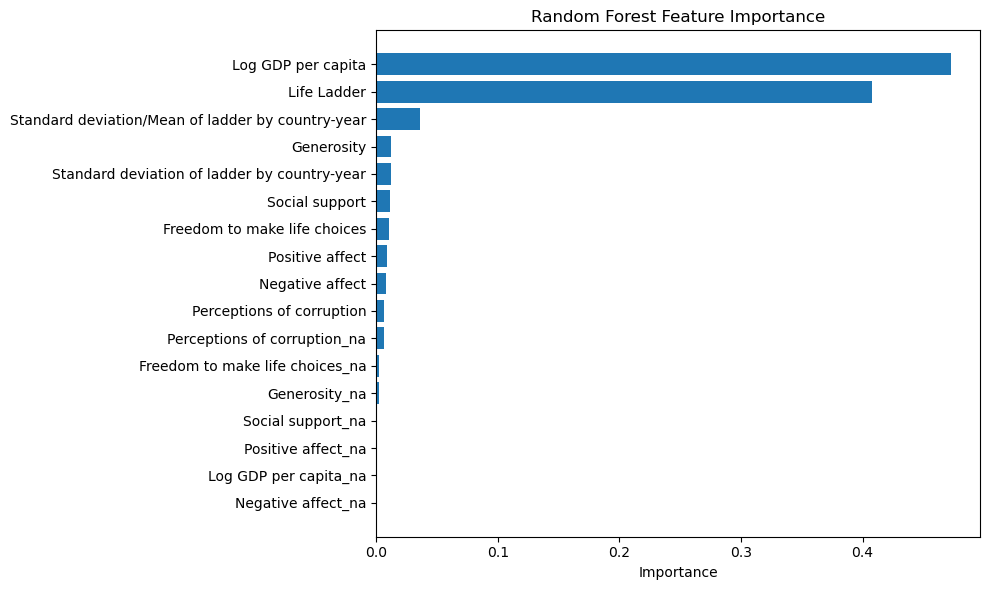

In [22]:
rf_best = RandomForestRegressor(
    **rand_search.best_params_,
    random_state=123
)
rf_best.fit(X_train, y_train)

y_pred_rf = rf_best.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Test MSE: {mse_rf:.4f}")
print(f"Random Forest Test R²: {r2_rf:.4f}")

import matplotlib.pyplot as plt
import numpy as np

importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), X.columns[indices][::-1])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Ridge Regression:
Test R²: 0.7090
CV R²:   0.7302
Test MSE: 18.0144

ElasticNet Regression:
Test R²: 0.7108
CV R²:   0.7263
Test MSE: 17.9032

Tuned Random Forest:
Test R²: 0.7065
CV R²:   0.7759
Test MSE: 18.1677



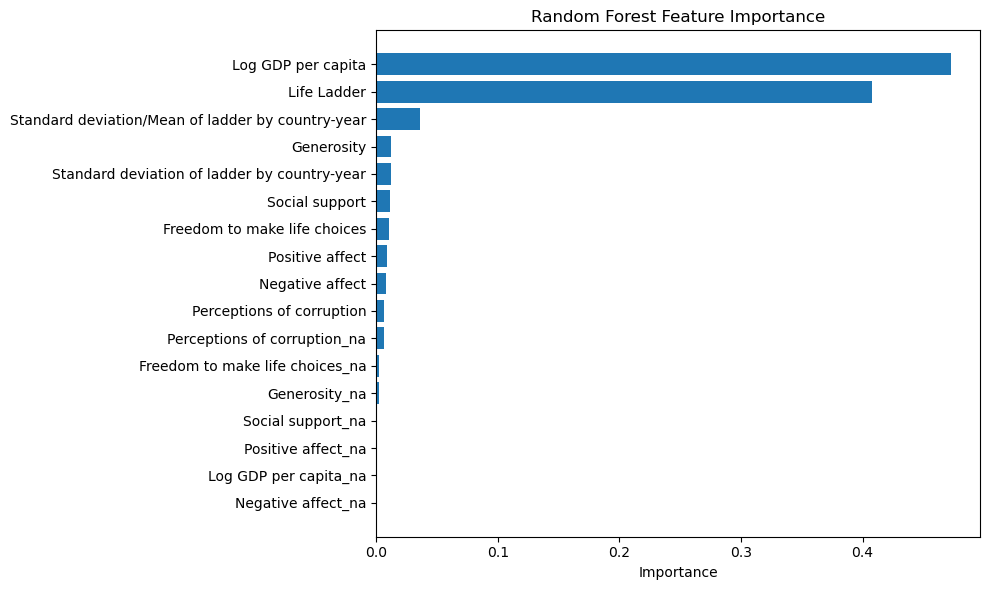

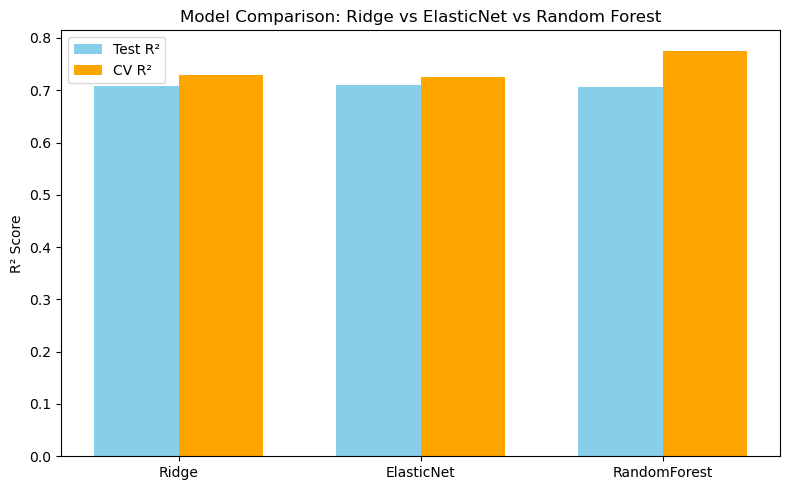

In [23]:
# MODEL COMPARISON PIPELINE
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# train/test Split 

# ridge regression 
ridge_model = Ridge(alpha=10, random_state=123)
ridge_model.fit(X_train, y_train)

y_pred_ridge = ridge_model.predict(X_test)
ridge_cv = cross_val_score(ridge_model, X_train, y_train, cv=5, scoring='r2').mean()

print("Ridge Regression:")
print(f"Test R²: {r2_score(y_test, y_pred_ridge):.4f}")
print(f"CV R²:   {ridge_cv:.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_ridge):.4f}\n")

# elasticnet regression
enet_model = ElasticNet(alpha=0.1, l1_ratio=0.9, random_state=123, max_iter=5000)
enet_model.fit(X_train, y_train)

y_pred_enet = enet_model.predict(X_test)
enet_cv = cross_val_score(enet_model, X_train, y_train, cv=5, scoring='r2').mean()

print("ElasticNet Regression:")
print(f"Test R²: {r2_score(y_test, y_pred_enet):.4f}")
print(f"CV R²:   {enet_cv:.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_enet):.4f}\n")

# tuned random forest
rf_best = RandomForestRegressor(
    n_estimators=203,
    max_depth=20,
    min_samples_split=7,
    min_samples_leaf=4,
    max_features=1.0,
    random_state=123
)
rf_best.fit(X_train, y_train)

y_pred_rf = rf_best.predict(X_test)
rf_cv = cross_val_score(rf_best, X_train, y_train, cv=3, scoring='r2').mean()

print("Tuned Random Forest:")
print(f"Test R²: {r2_score(y_test, y_pred_rf):.4f}")
print(f"CV R²:   {rf_cv:.4f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred_rf):.4f}\n")

# feature importance random forest
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(range(len(importances)), importances[indices][::-1], align='center')
plt.yticks(range(len(importances)), X.columns[indices][::-1])
plt.title("Random Forest Feature Importance")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# compare all models
models = ['Ridge', 'ElasticNet', 'RandomForest']
test_r2 = [
    r2_score(y_test, y_pred_ridge),
    r2_score(y_test, y_pred_enet),
    r2_score(y_test, y_pred_rf)
]

cv_r2 = [ridge_cv, enet_cv, rf_cv]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, test_r2, width, label='Test R²', color='skyblue')
plt.bar(x + width/2, cv_r2, width, label='CV R²', color='orange')
plt.xticks(x, models)
plt.ylabel("R² Score")
plt.title("Model Comparison: Ridge vs ElasticNet vs Random Forest")
plt.legend()
plt.tight_layout()
plt.show()


1. linear models perform better on test set
    - ridge and elastic net generalize better than random forest
    - probably due to small datast 
2. random forest shows higher cv r^2
    - CV R^2 = 0.7748 higher than linear models so forest is training well
    - Test R^2 = 0.6991 is lower so sign of overfitting to training folds
3. interpretability vs performance
    - ridge/elastic net: linear coefficients -> easier to explain which features matter
    - random forest: nonlinear -> more flexible but harder to interpret


## Workflow Summary
1. data cleaning
    - averaged country level data, handled missing values
    - removed features with too many NaNs and irrelevant columnds
2. feature engineering
    - added missingness indicators
    - scaled numeric features
3. modeling
    - baseline linear regression -> measured MSE and R^2
    - regularized linear models:
        - ridge regression
        - elasticnet regression 
    - ensemble models 
        - random forest
4. evaluation
    - cross validation r^2 vs test r^2
    - outlier handling and feature selection
    - feature importance analysis for random forest

## Observations
- linear models generalize slightly better on test data
- random forest shows stronger CV R^2 -> captures nonlinear patterns but slightly overfits
- elasticnet slightly improves CV performance while remaining interpretable

## Future directions
model selection:
predictive accuracy -> elasticnet and ridge are strong choices
nonlinear insights -> random forest helps but slightly overfits due to small dataset

data:
include more years or more granular features per country
explore interaction terms in linear models

reporting:
include feature importance plots, scatter plots of predicted vs actual, and 
optionally SHAP plots for Random Forest to show nonlinear effects.

limitations:
dataset is small (one row per country) → limits complexity
random forest overfits slightly → may improve with more data.

In this analysis, I modeled healthy life expectancy across countries using 
linear and ensemble methods. Ridge and ElasticNet regression provided robust 
and interpretable predictions, achieving test R² around 0.71. Random Forest 
captured nonlinear patterns with higher CV R² (0.77), but slightly lower test 
performance (R²=0.70), indicating mild overfitting. Key drivers of life 
expectancy include GDP per capita, social support, and freedom of choice. 
Future work could explore gradient boosting ensembles, additional feature 
interactions, and more granular temporal data to improve predictive accuracy.